# EDA Whitelist v3 - Verificación de Criterios

**Fecha:** 2025-12-13  
**Objetivo:** Verificar que la whitelist v3 cumple los criterios contractuales:
1. Whitelist tiene entre 240-250 dominios
2. TTC > 15% (más del 15% de URLs tienen `trusted_token_context == +1`)

**Fuentes:**
- Whitelist: `docs/whitelist.csv`
- Dataset base: `notebooks/dataset_v2.csv` (según MANIFIESTO_V3)
- Extractores: `features.loaders_v3`, `features.features_v3`


In [9]:
import pandas as pd
import sys
from pathlib import Path

# Añadir raíz al path
ROOT = Path(".").resolve().parent.parent
sys.path.insert(0, str(ROOT))

from features.loaders_v3 import initialize_v3, load_whitelist_v3
from features.features_v3 import extract_features_v3

print("✓ Imports completados")


✓ Imports completados


## 1. Verificación de Whitelist (240-250 dominios)


In [10]:
# Cargar whitelist
whitelist_path = ROOT / "docs" / "whitelist.csv"
whitelist = load_whitelist_v3(str(whitelist_path))

total_dominios = len(whitelist)
print(f"Total de dominios en whitelist: {total_dominios}")

# Verificar rango objetivo
objetivo_min = 240
objetivo_max = 250

if objetivo_min <= total_dominios <= objetivo_max:
    print(f"✓ CRITERIO CUMPLIDO: Whitelist tiene {total_dominios} dominios (rango objetivo: {objetivo_min}-{objetivo_max})")
    criterio_whitelist = True
else:
    print(f"✗ CRITERIO NO CUMPLIDO: Whitelist tiene {total_dominios} dominios (rango objetivo: {objetivo_min}-{objetivo_max})")
    criterio_whitelist = False


Total de dominios en whitelist: 245
✓ CRITERIO CUMPLIDO: Whitelist tiene 245 dominios (rango objetivo: 240-250)


## 2. Carga del Dataset v2 y Cálculo de TTC


In [11]:
# Cargar dataset v2
dataset_path = ROOT / "notebooks" / "dataset_v2.csv"

# Si no existe en notebooks, intentar en data/clean
if not dataset_path.exists():
    dataset_path = ROOT / "data" / "clean" / "dataset_v2.csv"

print(f"Cargando dataset desde: {dataset_path}")
df = pd.read_csv(dataset_path, encoding="utf-8", on_bad_lines="skip")

print(f"✓ Dataset cargado: {len(df)} filas")
print(f"Columnas: {list(df.columns)}")
print(f"\nPrimeras filas:")
df.head()


Cargando dataset desde: /Users/test/Desktop/phishing-detector/data/clean/dataset_v2.csv
✓ Dataset cargado: 482 filas
Columnas: ['url', 'label', 'sector', 'entidad', 'notas', 'campaign']

Primeras filas:


,url,label,sector,entidad,notas,campaign
0,https://www.caixabank.es/particular/banca-digi...,0,banca,caixabank,home bancaria oficial,NaN
1,https://www.ibercaja.es/particulares/,0,banca,ibercaja,NaN,NaN
2,https://www.wizink.es/tarjetas,0,banca,wizink,NaN,NaN
3,https://www.wizink.es/,0,banca,wizink,NaN,NaN
4,https://www.cetelem.es/credito-y-prestamos/,0,banca,cetelem,NaN,NaN


In [12]:
# Inicializar v3
print("Inicializando extractor v3...")
whitelist_set, constants = initialize_v3(
    whitelist_path=str(ROOT / "docs" / "whitelist.csv"),
    brands_path=str(ROOT / "docs" / "dominios_espanyoles.csv")
)

brands_set = constants["BRANDS_FROM_DOMAINS_ES"]

print(f"✓ Whitelist cargada: {len(whitelist_set)} dominios")
print(f"✓ Brands set cargado: {len(brands_set)} marcas")
print(f"✓ Constants disponibles: {list(constants.keys())}")


Inicializando extractor v3...
✓ Whitelist cargada: 245 dominios
✓ Brands set cargado: 198 marcas
✓ Constants disponibles: ['TLD_RISK', 'GLOBAL_NEUTRAL_DOMAINS', 'FREE_HOSTING', 'HTTP_WEIGHT', 'BRANDS_FROM_DOMAINS_ES']


In [13]:
# Calcular TTC para todas las URLs del dataset
print("Calculando trusted_token_context para todas las URLs...")

ttc_values = []
for idx, row in df.iterrows():
    url = row["url"]
    features = extract_features_v3(url, whitelist_set, brands_set, constants)
    # trusted_token_context es el índice 2 en FEATURES_V3
    ttc = features[2]
    ttc_values.append(ttc)
    
    if (idx + 1) % 100 == 0:
        print(f"  Procesadas {idx + 1}/{len(df)} URLs...")

df["trusted_token_context"] = ttc_values
print(f"✓ TTC calculado para {len(df)} URLs")


Calculando trusted_token_context para todas las URLs...
  Procesadas 100/482 URLs...
  Procesadas 200/482 URLs...
  Procesadas 300/482 URLs...
  Procesadas 400/482 URLs...
✓ TTC calculado para 482 URLs


## 3. Análisis de TTC y Verificación de Criterio (> 15%)


In [14]:
# Distribución de TTC
ttc_dist = df["trusted_token_context"].value_counts().sort_index()
print("Distribución de trusted_token_context:")
print(ttc_dist)
print(f"\nTotal URLs: {len(df)}")

# Calcular porcentaje de TTC == +1
ttc_positivo = (df["trusted_token_context"] == 1).sum()
porcentaje_ttc = (ttc_positivo / len(df)) * 100

print(f"\nURLs con TTC == +1: {ttc_positivo}")
print(f"Porcentaje de TTC == +1: {porcentaje_ttc:.2f}%")

# Verificar criterio
criterio_minimo = 15.0
if porcentaje_ttc > criterio_minimo:
    print(f"✓ CRITERIO CUMPLIDO: TTC > {criterio_minimo}% ({porcentaje_ttc:.2f}%)")
    criterio_ttc = True
else:
    print(f"✗ CRITERIO NO CUMPLIDO: TTC = {porcentaje_ttc:.2f}% (mínimo requerido: {criterio_minimo}%)")
    criterio_ttc = False


Distribución de trusted_token_context:
trusted_token_context
-1    305
 0     17
 1    160
Name: count, dtype: int64

Total URLs: 482

URLs con TTC == +1: 160
Porcentaje de TTC == +1: 33.20%
✓ CRITERIO CUMPLIDO: TTC > 15.0% (33.20%)


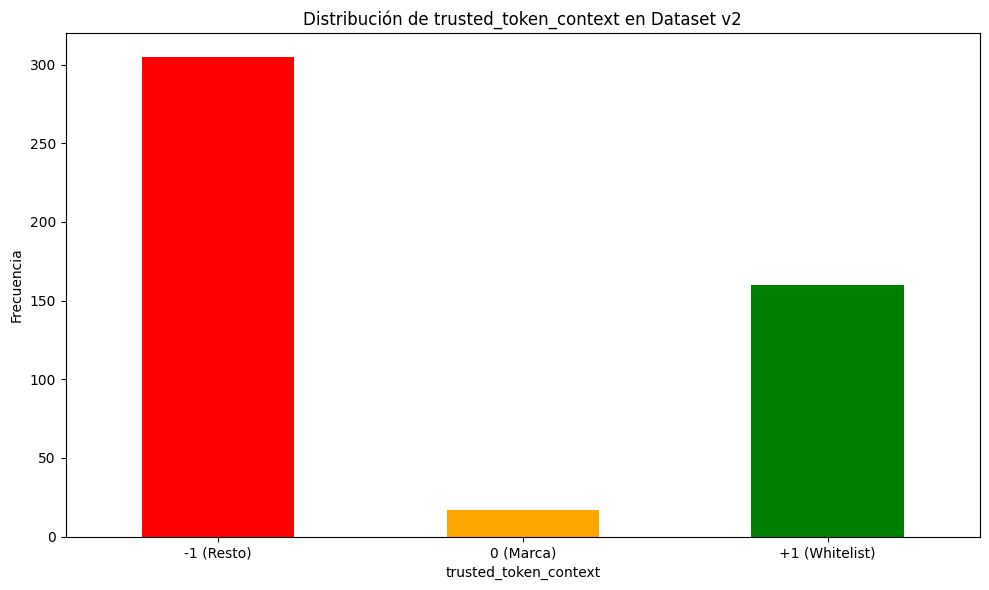


Desglose:
  TTC = -1 (Resto): 305 URLs
  TTC =  0 (Marca): 17 URLs
  TTC = +1 (Whitelist): 160 URLs


In [15]:
# Visualización de distribución TTC
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ttc_dist.plot(kind="bar", ax=ax, color=["red", "orange", "green"])
ax.set_xlabel("trusted_token_context")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución de trusted_token_context en Dataset v2")
ax.set_xticklabels(["-1 (Resto)", "0 (Marca)", "+1 (Whitelist)"], rotation=0)
plt.tight_layout()
plt.show()

print(f"\nDesglose:")
print(f"  TTC = -1 (Resto): {(df['trusted_token_context'] == -1).sum()} URLs")
print(f"  TTC =  0 (Marca): {(df['trusted_token_context'] == 0).sum()} URLs")
print(f"  TTC = +1 (Whitelist): {(df['trusted_token_context'] == 1).sum()} URLs")


## 4. Resumen Final y Gate EDA


In [16]:
print("=" * 80)
print("RESUMEN FINAL - GATE EDA")
print("=" * 80)

print(f"\n1. Criterio Whitelist (240-250 dominios):")
print(f"   Total dominios: {total_dominios}")
print(f"   Estado: {'✓ CUMPLIDO' if criterio_whitelist else '✗ NO CUMPLIDO'}")

print(f"\n2. Criterio TTC (> 15%):")
print(f"   Porcentaje TTC == +1: {porcentaje_ttc:.2f}%")
print(f"   Estado: {'✓ CUMPLIDO' if criterio_ttc else '✗ NO CUMPLIDO'}")

print(f"\n3. Gate EDA:")
if criterio_whitelist and criterio_ttc:
    print("   🟢 VERDE - Ambos criterios cumplidos")
    print("   ✓ El extractor v3 puede ejecutarse para regenerar features")
    gate_eda = "VERDE"
else:
    print("   🔴 ROJO - Al menos un criterio no cumplido")
    print("   ✗ Revisar whitelist o configuración antes de ejecutar extractor")
    gate_eda = "ROJO"

print("=" * 80)


RESUMEN FINAL - GATE EDA

1. Criterio Whitelist (240-250 dominios):
   Total dominios: 245
   Estado: ✓ CUMPLIDO

2. Criterio TTC (> 15%):
   Porcentaje TTC == +1: 33.20%
   Estado: ✓ CUMPLIDO

3. Gate EDA:
   🟢 VERDE - Ambos criterios cumplidos
   ✓ El extractor v3 puede ejecutarse para regenerar features


## 5. Documentación de Resultados

### Resumen Ejecutivo

**Fecha de ejecución:** 2025-12-13  
**Estado del Gate EDA:** 🟢 **VERDE**

### Criterios Verificados

| Criterio | Valor | Objetivo | Estado |
|----------|-------|----------|--------|
| **Whitelist (dominios)** | 245 | 240-250 | ✓ CUMPLIDO |
| **TTC > 15%** | 33.20% | > 15% | ✓ CUMPLIDO |

### Detalles Técnicos

- **Dataset analizado:** `data/clean/dataset_v2.csv` (482 URLs)
- **Whitelist cargada:** 245 dominios
- **Brands set cargado:** 198 marcas
- **Distribución TTC:**
  - TTC = -1 (Resto): 305 URLs (63.28%)
  - TTC = 0 (Marca): 17 URLs (3.53%)
  - TTC = +1 (Whitelist): 160 URLs (33.20%)

### Conclusión

✅ **Ambos criterios contractuales se cumplen.**  
✅ **El extractor v3 puede ejecutarse para regenerar features del dataset v3.**

### Próximos Pasos

1. Ejecutar `extract_features_dataset_v3()` sobre `notebooks/dataset_v2.csv`
2. Generar `dataset_v3_features.csv` con las 7 features contractuales
3. Validar que no hay NaN en features
4. Generar metadata JSON con checksums
